In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target
feature_names = cancer.feature_names


In [3]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
# Scale the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Create and train the SVC model with specified parameters
svc_model = SVC(C=5, degree=4, gamma=0.1, kernel='poly', random_state=42)
svc_model.fit(X_train_scaled, y_train)

SVC(C=5, degree=4, gamma=0.1, kernel='poly', random_state=42)

In [6]:
# Check model accuracy
y_pred = svc_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.7895


In [ ]:
# Permutation Importance
"""
By randomly shuffling each feature and measuring the drop in model performance, we can estimate how important each feature is
"""
result = permutation_importance(svc_model, X_test_scaled, y_test,
                               n_repeats=10, random_state=42, n_jobs=-1)


In [8]:
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean,
    'Std': result.importances_std
})
perm_importance_df = perm_importance_df.sort_values('Importance', ascending=False)
print(perm_importance_df.head(10))


                    Feature  Importance       Std
25        worst compactness    0.049708  0.019788
26          worst concavity    0.049708  0.014384
7       mean concave points    0.046784  0.012812
20             worst radius    0.037427  0.019780
6            mean concavity    0.035673  0.013450
27     worst concave points    0.033333  0.015035
29  worst fractal dimension    0.031579  0.013129
22          worst perimeter    0.031579  0.017583
15        compactness error    0.030994  0.017747
24         worst smoothness    0.030409  0.011637


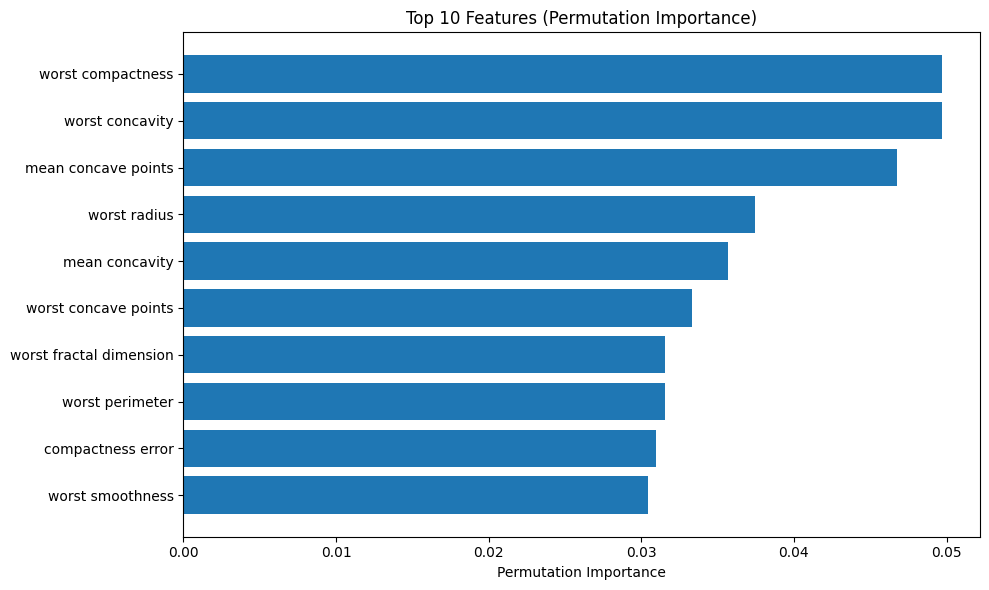

In [11]:
# Visualize the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'][:10], perm_importance_df['Importance'][:10])
plt.xlabel('Permutation Importance')
plt.title('Top 10 Features (Permutation Importance)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('permutation_importance.png')

In [ ]:
# Feature Elimination
"""
neutralize each feature (one at a time) by setting its values to the mean, then measure the drop in accuracy
"""
def evaluate_feature_importance_by_elimination(model, X, y, feature_names):
    # Get baseline accuracy
    baseline_accuracy = accuracy_score(y, model.predict(X))
    feature_importance = []

    # For each feature, eliminate it and check accuracy difference
    for i in range(X.shape[1]):
        X_modified = X.copy()
        # Replace feature with its mean (neutralize it)
        feature_mean = X[:, i].mean()
        X_modified[:, i] = feature_mean

        # Evaluate new accuracy
        new_accuracy = accuracy_score(y, model.predict(X_modified))

        # Importance is the drop in accuracy
        importance = baseline_accuracy - new_accuracy
        feature_importance.append(importance)

    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })

    return importance_df.sort_values('Importance', ascending=False)


In [13]:
elimination_importance = evaluate_feature_importance_by_elimination(
    svc_model, X_test_scaled, y_test, feature_names)
print(elimination_importance.head(10))


                    Feature  Importance
7       mean concave points    0.070175
6            mean concavity    0.058480
25        worst compactness    0.058480
26          worst concavity    0.040936
22          worst perimeter    0.035088
14         smoothness error    0.035088
4           mean smoothness    0.029240
20             worst radius    0.029240
15        compactness error    0.029240
29  worst fractal dimension    0.023392


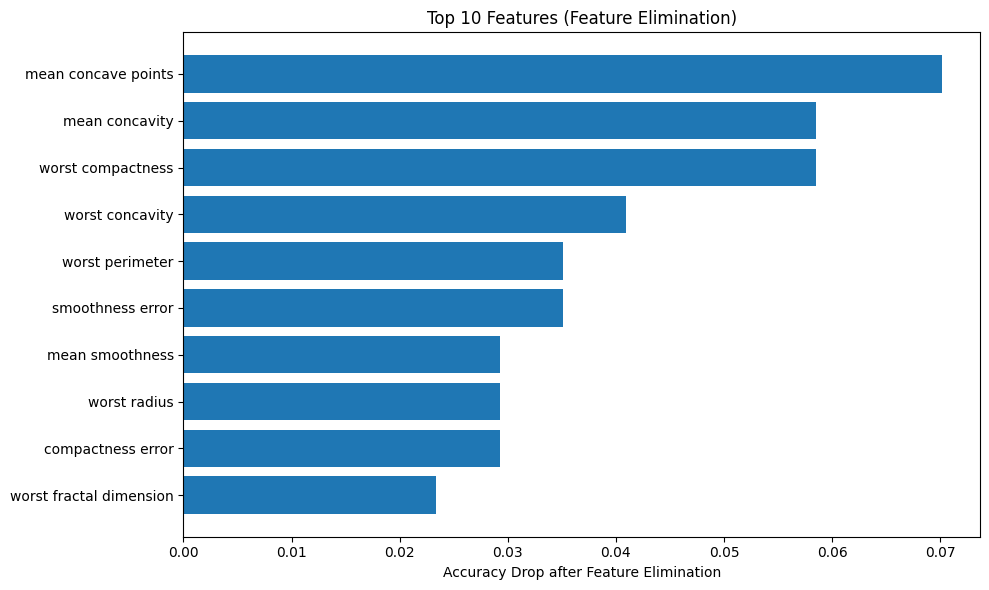

In [14]:
plt.figure(figsize=(10, 6))
plt.barh(elimination_importance['Feature'][:10], elimination_importance['Importance'][:10])
plt.xlabel('Accuracy Drop after Feature Elimination')
plt.title('Top 10 Features (Feature Elimination)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('elimination_importance.png')


In [ ]:
# Training Linear SVC on the same data
"""
Train a linear SVC on the same data and use its coefficients as an approximation
"""
from sklearn.svm import LinearSVC
from sklearn.inspection import permutation_importance

# Train a Linear SVC
linear_svc = LinearSVC(dual="auto", C=5, random_state=42)
linear_svc.fit(X_train_scaled, y_train)


LinearSVC(C=5, random_state=42)

In [16]:
# Get feature importance from coefficients
coef = np.abs(linear_svc.coef_[0])
linear_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})
linear_importance_df = linear_importance_df.sort_values('Coefficient', ascending=False)
print(linear_importance_df.head(10))


                    Feature  Coefficient
7       mean concave points     2.705737
10             radius error     2.420699
5          mean compactness     2.399091
20             worst radius     1.510110
23               worst area     1.464702
28           worst symmetry     1.431374
26          worst concavity     1.269106
19  fractal dimension error     1.251931
17     concave points error     1.190225
21            worst texture     0.983884


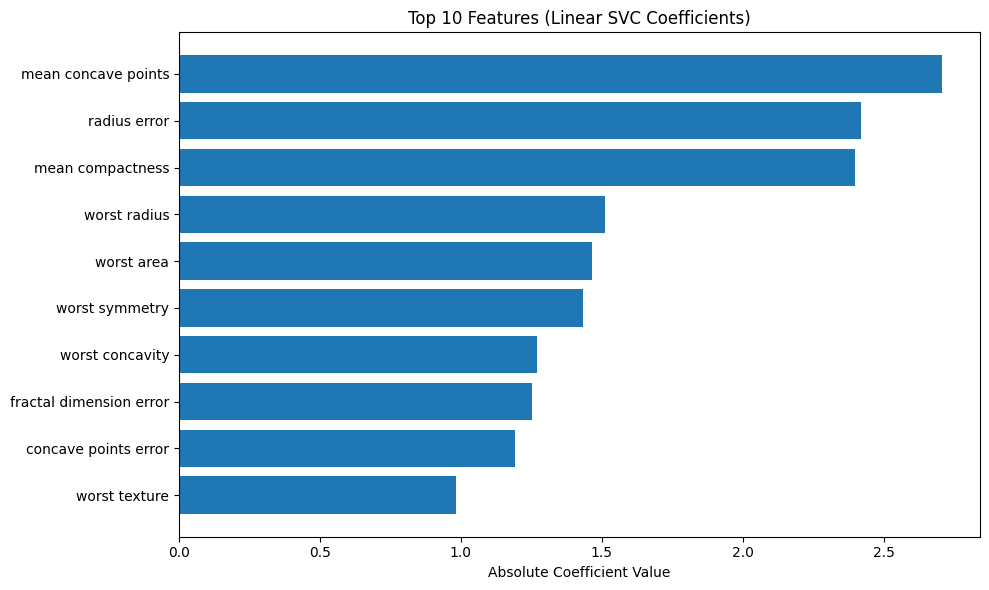

In [17]:
plt.figure(figsize=(10, 6))
plt.barh(linear_importance_df['Feature'][:10], linear_importance_df['Coefficient'][:10])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 10 Features (Linear SVC Coefficients)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('linear_svc_coefficients.png')


In [18]:
# SHAP Values
!pip install shap
import shap

  0%|          | 0/100 [00:00<?, ?it/s]

                    Feature  SHAP Importance
10             radius error         1.638868
13               area error         1.465220
12          perimeter error         1.241417
25        worst compactness         0.897569
26          worst concavity         0.804798
29  worst fractal dimension         0.794850
20             worst radius         0.618130
23               worst area         0.598624
7       mean concave points         0.591214
22          worst perimeter         0.556902


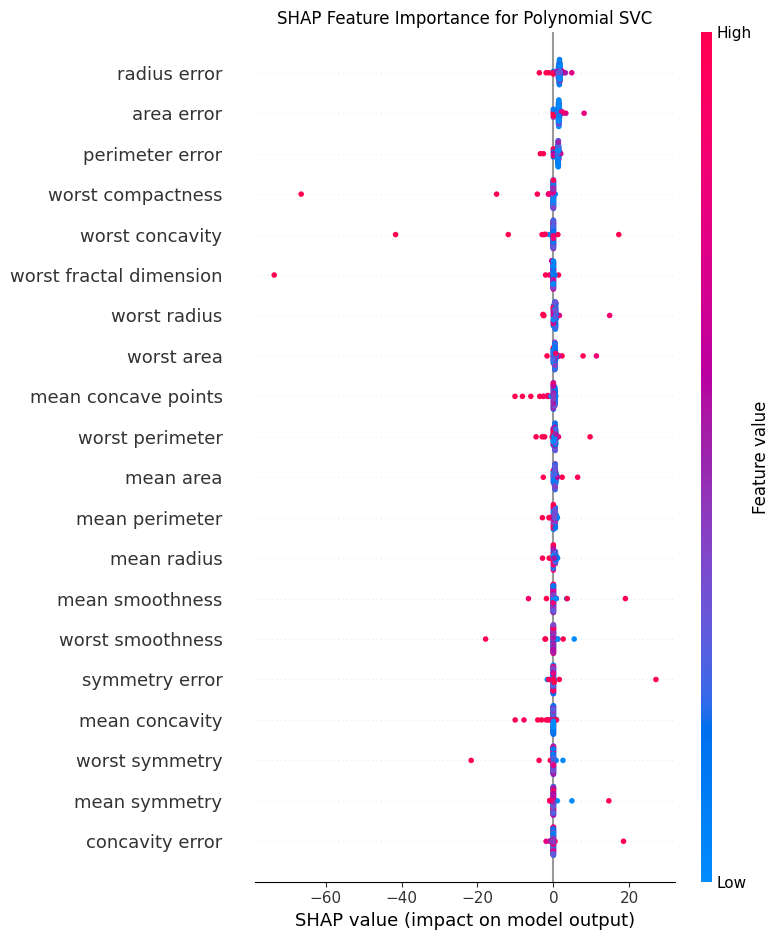

In [ ]:
"""
Based on game theory, SHAP values assign each feature an importance value for a particular prediction
"""

try:
    import shap

    # Create explainer
    background = shap.kmeans(X_train_scaled, 10)  # Create a summary of the training data
    explainer = shap.KernelExplainer(svc_model.decision_function, background)

    # Calculate SHAP values for a sample of test data (using small sample for speed)
    n_samples = min(100, X_test_scaled.shape[0])
    shap_values = explainer.shap_values(X_test_scaled[:n_samples])

    # Plot summary
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_scaled[:n_samples], feature_names=feature_names, show=False)
    plt.title('SHAP Feature Importance for Polynomial SVC')
    plt.tight_layout()
    plt.savefig('shap_summary.png')

    # Get mean absolute SHAP values for feature importance ranking
    shap_importance = np.abs(shap_values).mean(axis=0)
    shap_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP Importance': shap_importance
    })
    shap_importance_df = shap_importance_df.sort_values('SHAP Importance', ascending=False)
    print(shap_importance_df.head(10))

except ImportError:
    print("SHAP library not available. To install run: pip install shap")
    pass

In [ ]:
# RFE with CV using a linear estimator (approximation)
"""
Recursive Feature Elimination with Cross-Validation (RFECV)
Recursively removes features and evaluates model performance to determine feature ranking.

"""
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Use Linear SVC for RFE
linear_svc_rfe = LinearSVC(dual="auto", random_state=42)
cv = StratifiedKFold(5)


In [21]:
# Define RFECV
rfecv = RFECV(
    estimator=linear_svc_rfe,
    step=1,
    cv=cv,
    scoring='accuracy',
    min_features_to_select=1
)

# Fit RFECV
rfecv.fit(X_train_scaled, y_train)


RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LinearSVC(random_state=42), scoring='accuracy')

In [22]:
# Get ranked features
importance_ranks = np.zeros(X_train_scaled.shape[1])
importance_ranks[rfecv.support_] = rfecv.ranking_[rfecv.support_]
importance_ranks[~rfecv.support_] = rfecv.ranking_[~rfecv.support_] + max(rfecv.ranking_[rfecv.support_])

# Create ranking DataFrame (lower rank = more important)
rfe_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'RFE Rank': importance_ranks
})
rfe_importance_df = rfe_importance_df.sort_values('RFE Rank')
print(rfe_importance_df.head(10))


                   Feature  RFE Rank
2           mean perimeter       1.0
7      mean concave points       1.0
6           mean concavity       1.0
5         mean compactness       1.0
11           texture error       1.0
10            radius error       1.0
9   mean fractal dimension       1.0
8            mean symmetry       1.0
13              area error       1.0
23              worst area       1.0


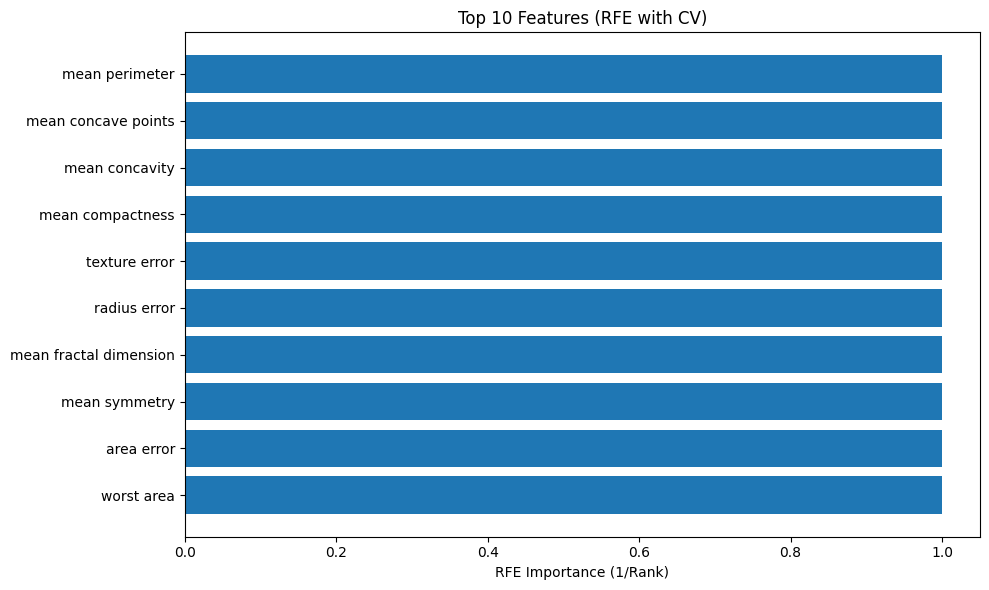

In [23]:
# Visualize
plt.figure(figsize=(10, 6))
plt.barh(rfe_importance_df['Feature'][:10], 1/rfe_importance_df['RFE Rank'][:10])
plt.xlabel('RFE Importance (1/Rank)')
plt.title('Top 10 Features (RFE with CV)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('rfe_importance.png')

In [24]:
print("\nComparing Top 5 Features Across Methods:")
print("-" * 50)
comparison = pd.DataFrame({
    'Permutation': perm_importance_df['Feature'][:5].values,
    'Elimination': elimination_importance['Feature'][:5].values,
    'Linear Coef': linear_importance_df['Feature'][:5].values,
    'RFE': rfe_importance_df['Feature'][:5].values
})

try:
    comparison['SHAP'] = shap_importance_df['Feature'][:5].values
except:
    pass

print(comparison)



Comparing Top 5 Features Across Methods:
--------------------------------------------------
           Permutation          Elimination          Linear Coef  \
0    worst compactness  mean concave points  mean concave points   
1      worst concavity       mean concavity         radius error   
2  mean concave points    worst compactness     mean compactness   
3         worst radius      worst concavity         worst radius   
4       mean concavity      worst perimeter           worst area   

                   RFE               SHAP  
0       mean perimeter       radius error  
1  mean concave points         area error  
2       mean concavity    perimeter error  
3     mean compactness  worst compactness  
4        texture error    worst concavity  


In [25]:
# Calculate consensus ranking
all_rankings = {}
methods = ['Permutation', 'Elimination', 'Linear Coef', 'RFE']
feature_votes = {feature: 0 for feature in feature_names}

for method, top_features in comparison.items():
    for i, feature in enumerate(top_features):
        # Add votes (inverse of position, so top feature gets more votes)
        feature_votes[feature] += 5 - i

# Create consensus ranking
consensus_ranking = pd.DataFrame({
    'Feature': list(feature_votes.keys()),
    'Consensus Score': list(feature_votes.values())
}).sort_values('Consensus Score', ascending=False)

print("\nConsensus Feature Ranking:")
print(consensus_ranking.head(10))



Consensus Feature Ranking:
                Feature  Consensus Score
7   mean concave points               17
25    worst compactness               10
10         radius error                9
6        mean concavity                8
26      worst concavity                7
5      mean compactness                5
2        mean perimeter                5
20         worst radius                4
13           area error                4
12      perimeter error                3


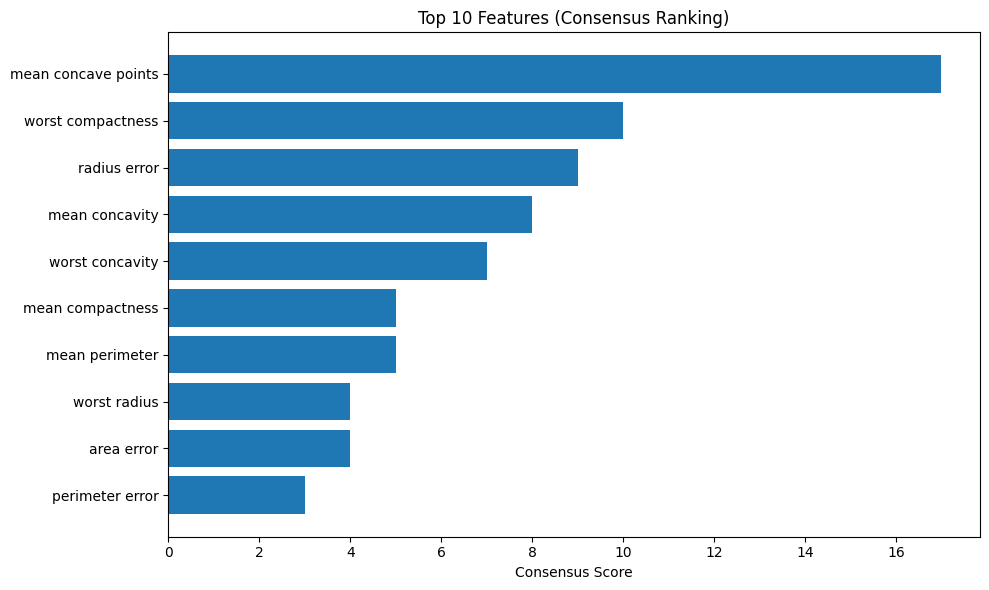

In [26]:
plt.figure(figsize=(10, 6))
plt.barh(consensus_ranking['Feature'][:10], consensus_ranking['Consensus Score'][:10])
plt.xlabel('Consensus Score')
plt.title('Top 10 Features (Consensus Ranking)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('consensus_ranking.png')

plt.show()